In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 500)

import statsmodels.api as sm
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt
from scipy import stats

rd = pd.read_excel('/sc/arion/projects/GENECAD/Robert/Drug_Phewas/RareDrug/Resources/combined_phecodex_list.xlsx')
cd = rd.loc[rd['Type'] == 'Common']

def cb(series):
    return series.apply(lambda x: 1 if x > 0 else 0)

import os
import matplotlib
import matplotlib.font_manager as font_manager

font_path = '/sc/arion/projects/GENECAD/Robert/arial.ttf'
assert os.path.exists(font_path)
font_manager.fontManager.addfont(font_path)
prop = font_manager.FontProperties(fname=font_path)

matplotlib.rc('font', family='sans-serif')
matplotlib.rcParams.update({
    'font.size': 12,
    'font.sans-serif': prop.get_name(),
    'axes.titlesize': 12
})


In [2]:
alldata = pd.read_pickle('./Final/ml_input.pkl')
indata = alldata.loc[alldata['drug_gene'] == 1]

ind = indata.groupby('phecode')['indication'].max().reset_index()
ind = ind.loc[ind['indication'] == 1]
indata = indata.loc[indata['phecode'].isin(ind['phecode'])]
print(indata['id'].nunique(), indata['phecode'].nunique(), indata['gene'].nunique())
print(indata['indication'].sum())

#####

clin = ['clingen','eva','gene2phenotype','genomics_england','omim','orphanet','uniprot_literature', 'uniprot_variants']
ot_clin = ['clingen','eva','gene2phenotype','genomics_england','orphanet','uniprot_literature', 'uniprot_variants']
ot = ['clin_ot','hgmd','gwas_credible_sets','expression_atlas','impc','europepmc']
mantis = ['mantis']
cc = ['cc_common_max_p','cc_rare_max_p','cc_rare_burden_max_p','cc_ultrarare_max_p']


356272 112 3181
5912


In [12]:
nz = indata[ot+mantis+['indication']].fillna(0)
nz[nz > 0] = 1
nz = nz.join(indata['id'])
nz = nz.set_axis(['Clinical genetics','HGMD','L2G','Gene expression','Mouse models','Text mining','Mantis-ML','Indication','ID'],axis=1)
nz = pd.melt(nz, id_vars=['ID','Indication'])
nz = nz.loc[nz['value'] == 1]
nz = nz.groupby('variable')['Indication'].value_counts().reset_index()
nz['Indication'] = nz['Indication'].map({0:'Non-indicated',1:'Indicated'})
nz['variable'] = pd.Categorical(nz['variable'], ['Clinical genetics','Gene expression','HGMD','L2G','Mouse models','Text mining','Mantis-ML'])
nz = nz.sort_values('variable')


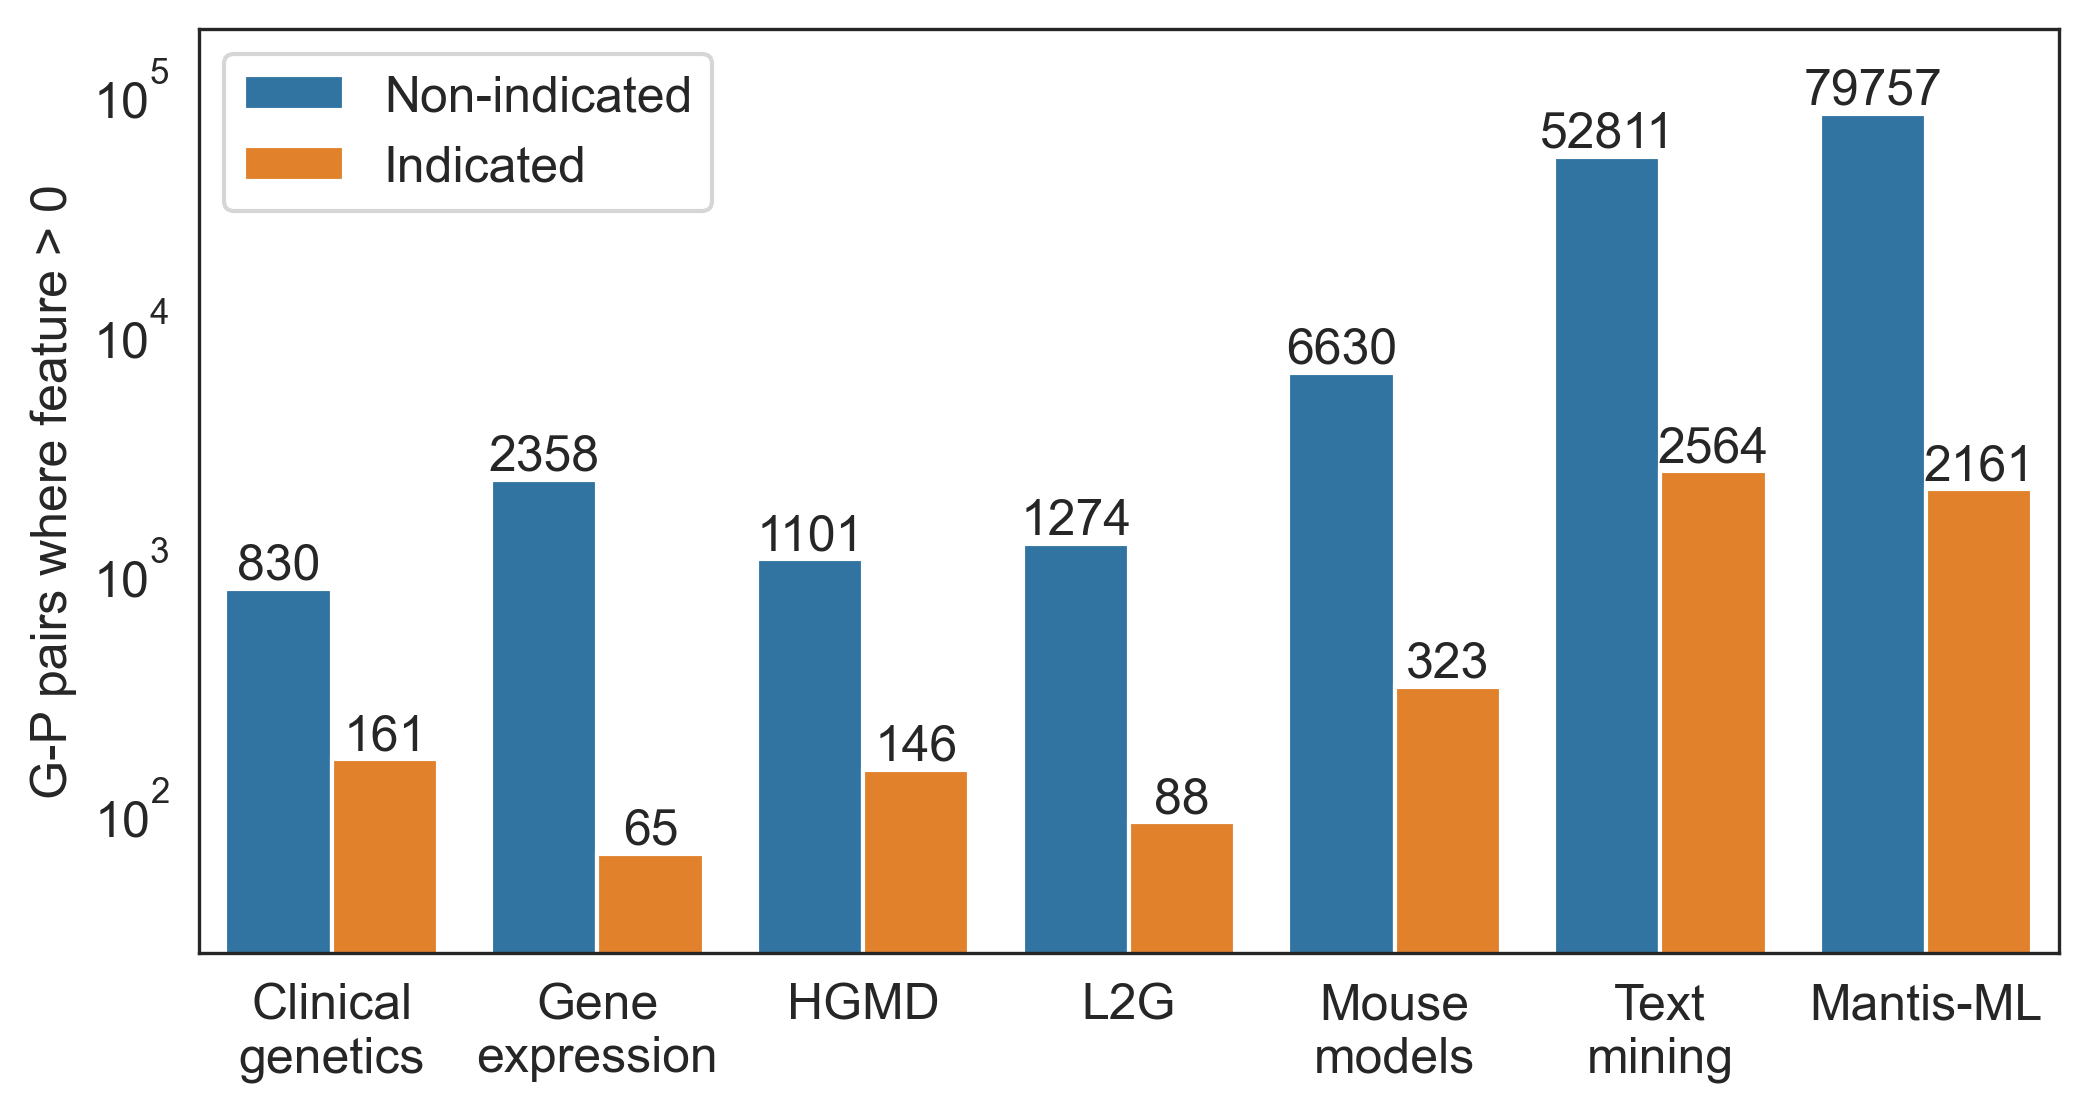

In [13]:
plt.figure(figsize=(8, 4), dpi=300)
sns.set_style('white')

ax = sns.barplot(nz, x='variable', y='count', hue='Indication')
for container in ax.containers:
    ax.bar_label(container)

dl = ['Clinical\ngenetics','Gene\nexpression','HGMD','L2G','Mouse\nmodels','Text\nmining','Mantis-ML']
plt.xticks(np.arange(len(dl)), dl, rotation=0, ha='center')

#plt.xticks(rotation=15, ha='right')
plt.xlabel('')
plt.yscale('log')
plt.ylim([25,180000])
plt.ylabel('G-P pairs where feature > 0')
plt.legend(title='')

In [14]:
results = []
feat_cols = ot+cc+mantis
lr_cols = ['Clinical genetics','HGMD','L2G','Gene expression','Mouse models','Text mining',
           'Common variants','Rare variants','Rare variants (gene-level)','Ultrarare variants (gene-level)','Mantis-ML']

lr_df = indata[['phecode_category','indication'] + feat_cols]
lr_df = lr_df.set_axis(['phecode_category','indication','Clinical genetics','HGMD','L2G','Gene expression','Mouse models','Text mining',
                        'Common variants','Rare variants','Rare variants (gene-level)','Ultrarare variants (gene-level)','Mantis-ML'],axis=1)
lr_df['Mantis-ML'] = lr_df['Mantis-ML'].fillna(0)


for col in lr_cols:
    temp_df = lr_df.copy()
    if col in ['Common variants']:
        temp_df = temp_df.loc[(temp_df[col].notna()) & (temp_df[col] > 0.01)]
    try:  
        X = temp_df[['phecode_category'] + [col]]
        X[col] = X[col].fillna(0)
        X = pd.get_dummies(X, columns=['phecode_category'], drop_first=True).astype(float)
        # Except for genetic associations, binarize as 1 or 0
        if col not in ['Common variants','Rare variants','Rare variants (gene-level)','Ultrarare variants (gene-level)']:
            X.loc[X[col] > 0, col] = 1
            X.loc[X[col] <= 0, col] = 0
        X = sm.add_constant(X)
        y = temp_df['indication']
        
        model = sm.Logit(y, X)
        res = model.fit(disp=0, maxiter=1000)
        
        odds_ratio = np.exp(res.params[col])
        conf = res.conf_int().loc[col]
        conf_odds_ratio = np.exp(conf)
        p_value = res.pvalues[col]
        
        results.append({
            'Column': col,
            'Odds Ratio': odds_ratio,
            '95% Lower': conf_odds_ratio[0],
            '95% Upper': conf_odds_ratio[1],
            'p-value': p_value
        })
        
        print(col)
    except:
        continue

df = pd.DataFrame(results)


Clinical genetics
HGMD
L2G
Gene expression
Mouse models
Text mining
Common variants
Rare variants
Rare variants (gene-level)
Ultrarare variants (gene-level)
Mantis-ML


In [24]:
df

,Column,Odds Ratio,95% Lower,95% Upper,p-value
0,Clinical genetics,10.406237,8.730240,12.403985,1.184870e-150
1,HGMD,7.260009,6.067276,8.687216,6.196353e-104
2,L2G,3.578547,2.867522,4.465876,1.626245e-29
3,Gene expression,1.686148,1.313370,2.164734,4.160900e-05
4,Mouse models,2.859981,2.544524,3.214546,1.656417e-69
5,Text mining,3.986120,3.777526,4.206232,0.000000e+00
6,Common variants,1.153597,1.102606,1.206946,5.841639e-10
7,Rare variants,1.012825,0.992965,1.033083,2.072137e-01
8,Rare variants (gene-level),1.024337,1.004305,1.044768,1.702128e-02
9,Ultrarare variants (gene-level),1.103278,1.064199,1.143792,9.214090e-08


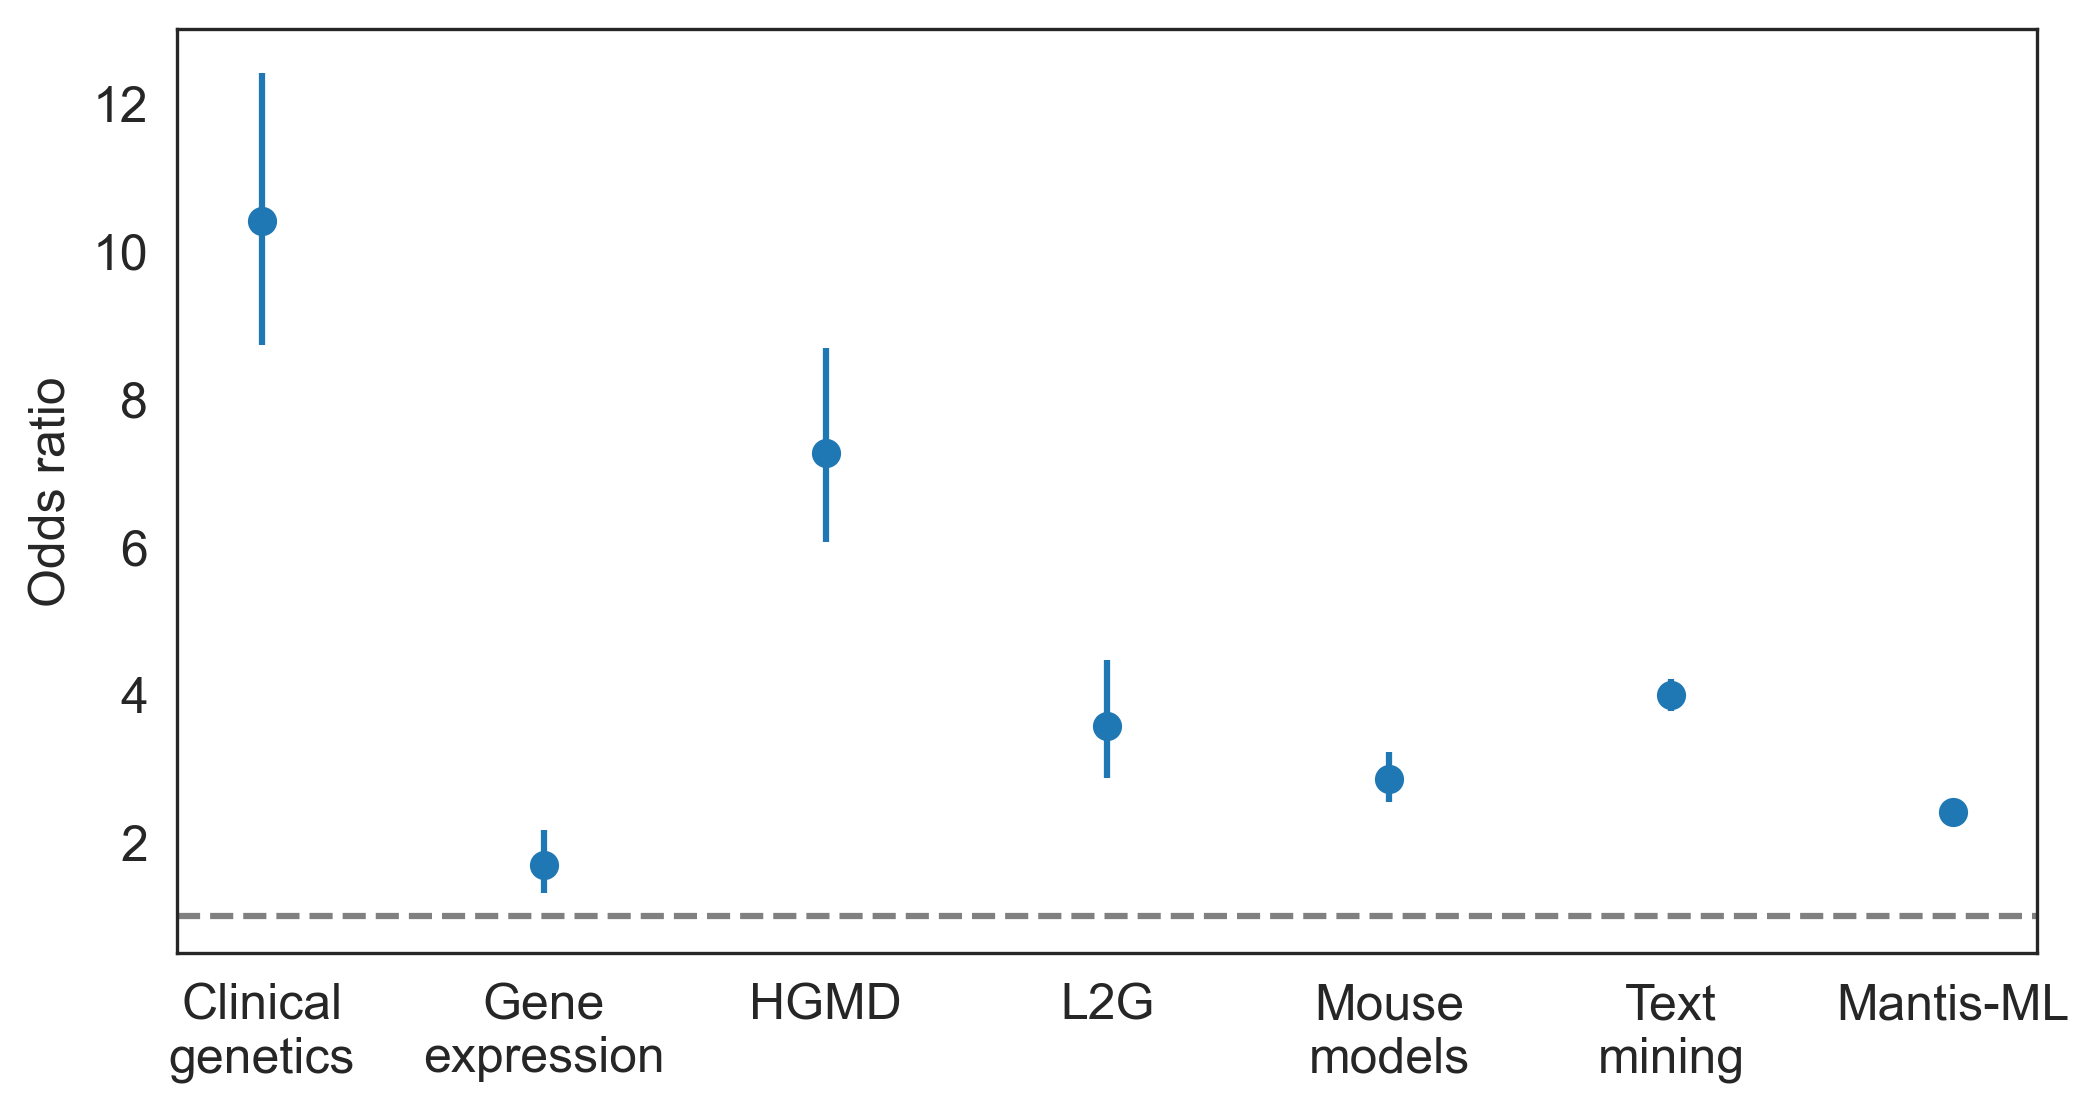

In [17]:
plot = df.loc[~df['Column'].str.contains('variants|eQTL')]
plot['Column'] = pd.Categorical(plot['Column'], ['Clinical genetics','Gene expression','HGMD','L2G','Mouse models','Text mining','Mantis-ML'])
plot = plot.sort_values('Column')

plt.figure(figsize=(8, 4), dpi=300)
sns.set_style('white')

diseases = plot['Column'].unique()
width = 0.2

plt.errorbar(plot['Column'], plot['Odds Ratio'],
             yerr=[plot['Odds Ratio'] - plot['95% Lower'],
                   plot['95% Upper'] - plot['Odds Ratio']],
             fmt='o')

dl = ['Clinical\ngenetics','Gene\nexpression','HGMD','L2G','Mouse\nmodels','Text\nmining','Mantis-ML']
plt.xticks(np.arange(len(diseases)), dl, rotation=0, ha='center')
plt.xlabel('')
plt.ylabel('Odds ratio')
plt.axhline(y=1, color='gray', linestyle='--')
plt.ylim([0.5,13])
#plt.yscale('log', base=2)

plt.show()


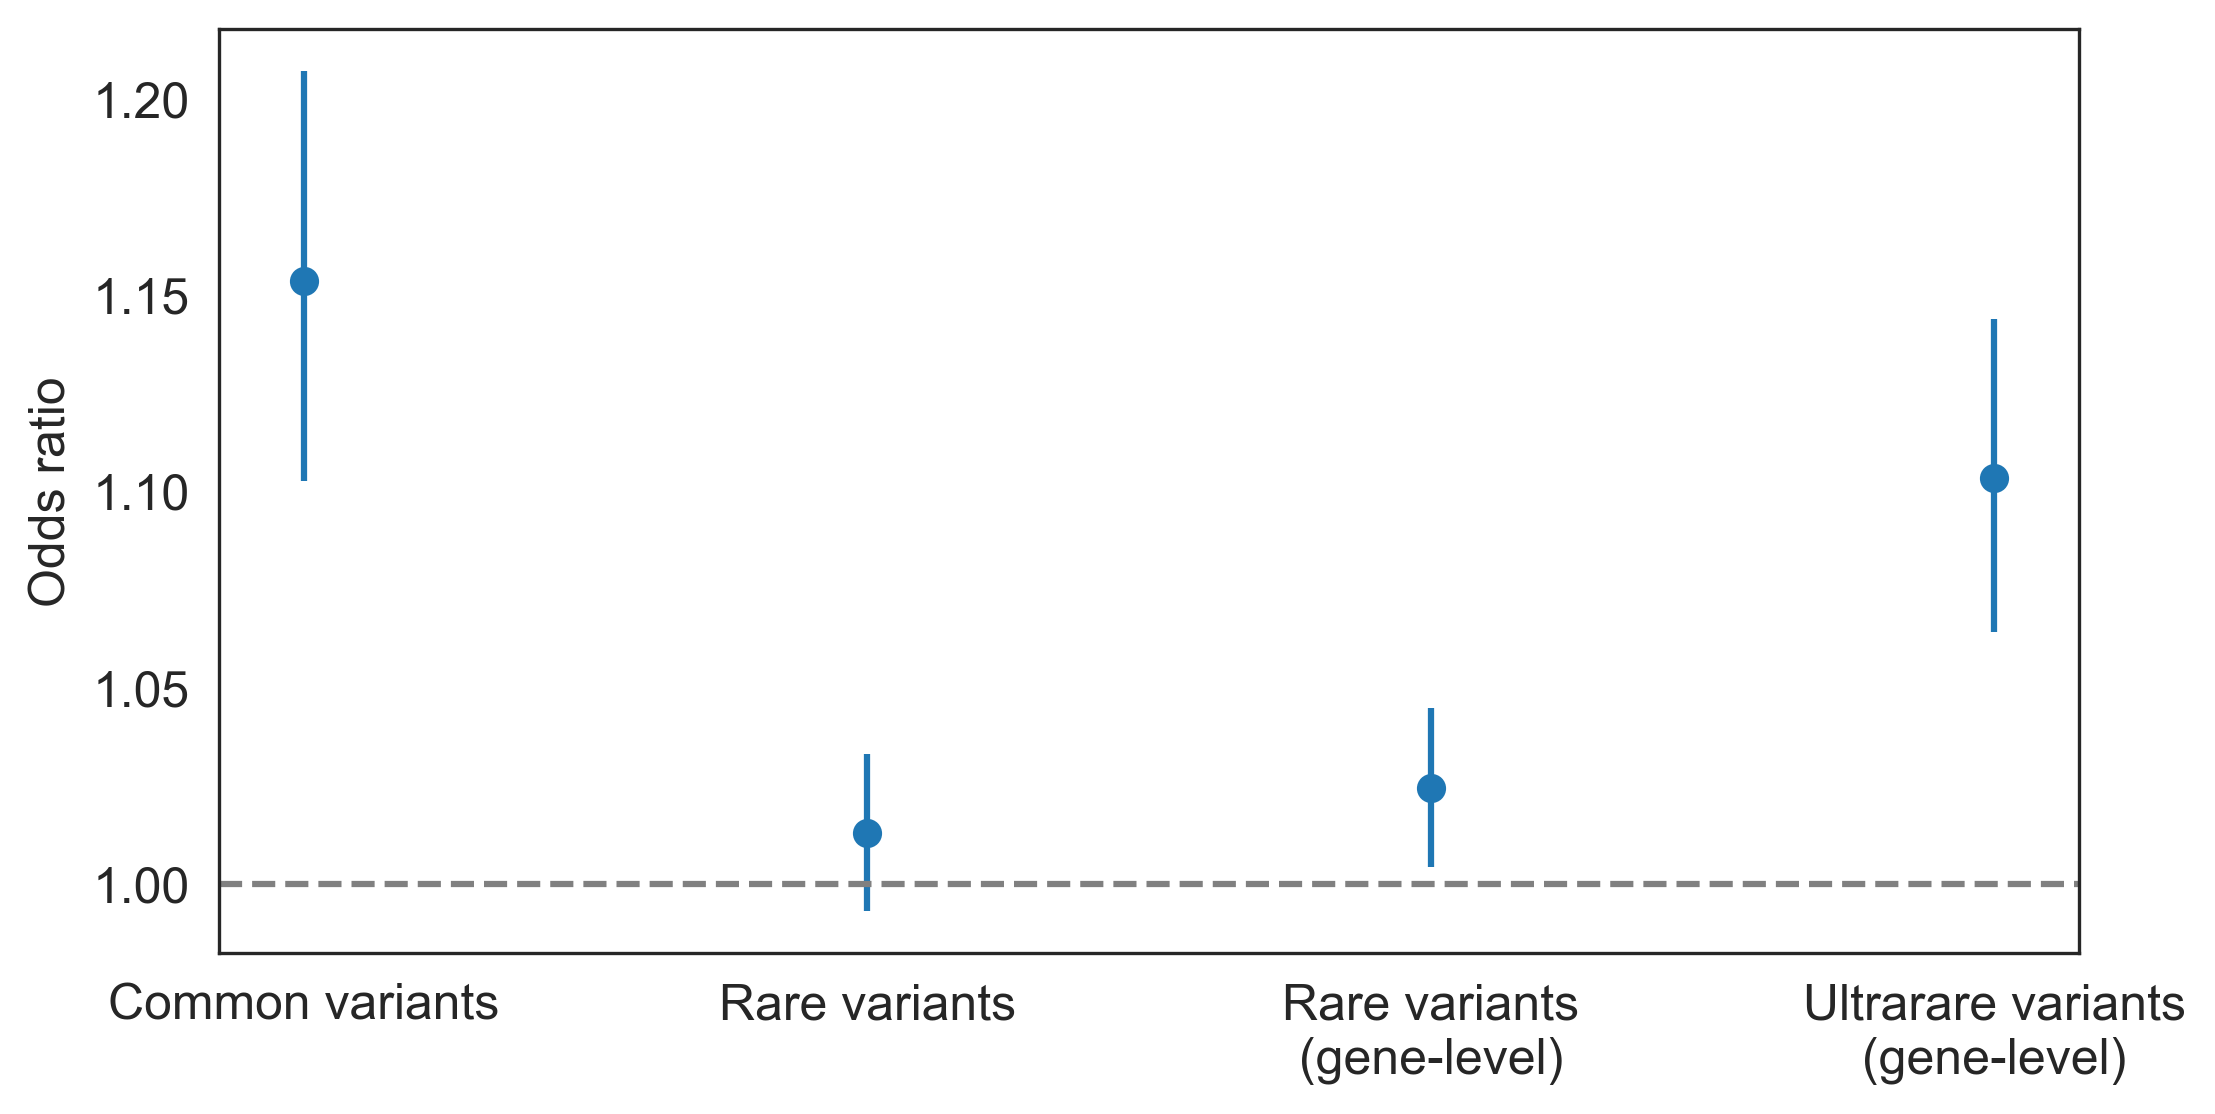

In [19]:
plot = df.loc[df['Column'].str.contains('variants|eQTL')]
plot['Column'] = pd.Categorical(plot['Column'], ['Common variants','Rare variants','Rare variants (gene-level)','Ultrarare variants (gene-level)'])
plot = plot.sort_values('Column')

plt.figure(figsize=(8, 4), dpi=300)
sns.set_style('white')

diseases = plot['Column'].unique()
width = 0.2

plt.errorbar(plot['Column'], plot['Odds Ratio'],
             yerr=[plot['Odds Ratio'] - plot['95% Lower'],
                   plot['95% Upper'] - plot['Odds Ratio']],
             fmt='o')

dl = ['Common variants','Rare variants','Rare variants\n(gene-level)','Ultrarare variants\n(gene-level)']
plt.xticks(np.arange(len(diseases)), dl, rotation=0, ha='center')
plt.xlabel('')
plt.ylabel('Odds ratio')
plt.axhline(y=1, color='gray', linestyle='--')
#plt.ylim([0.97,1.2])
#plt.yscale('log', base=2)

plt.show()


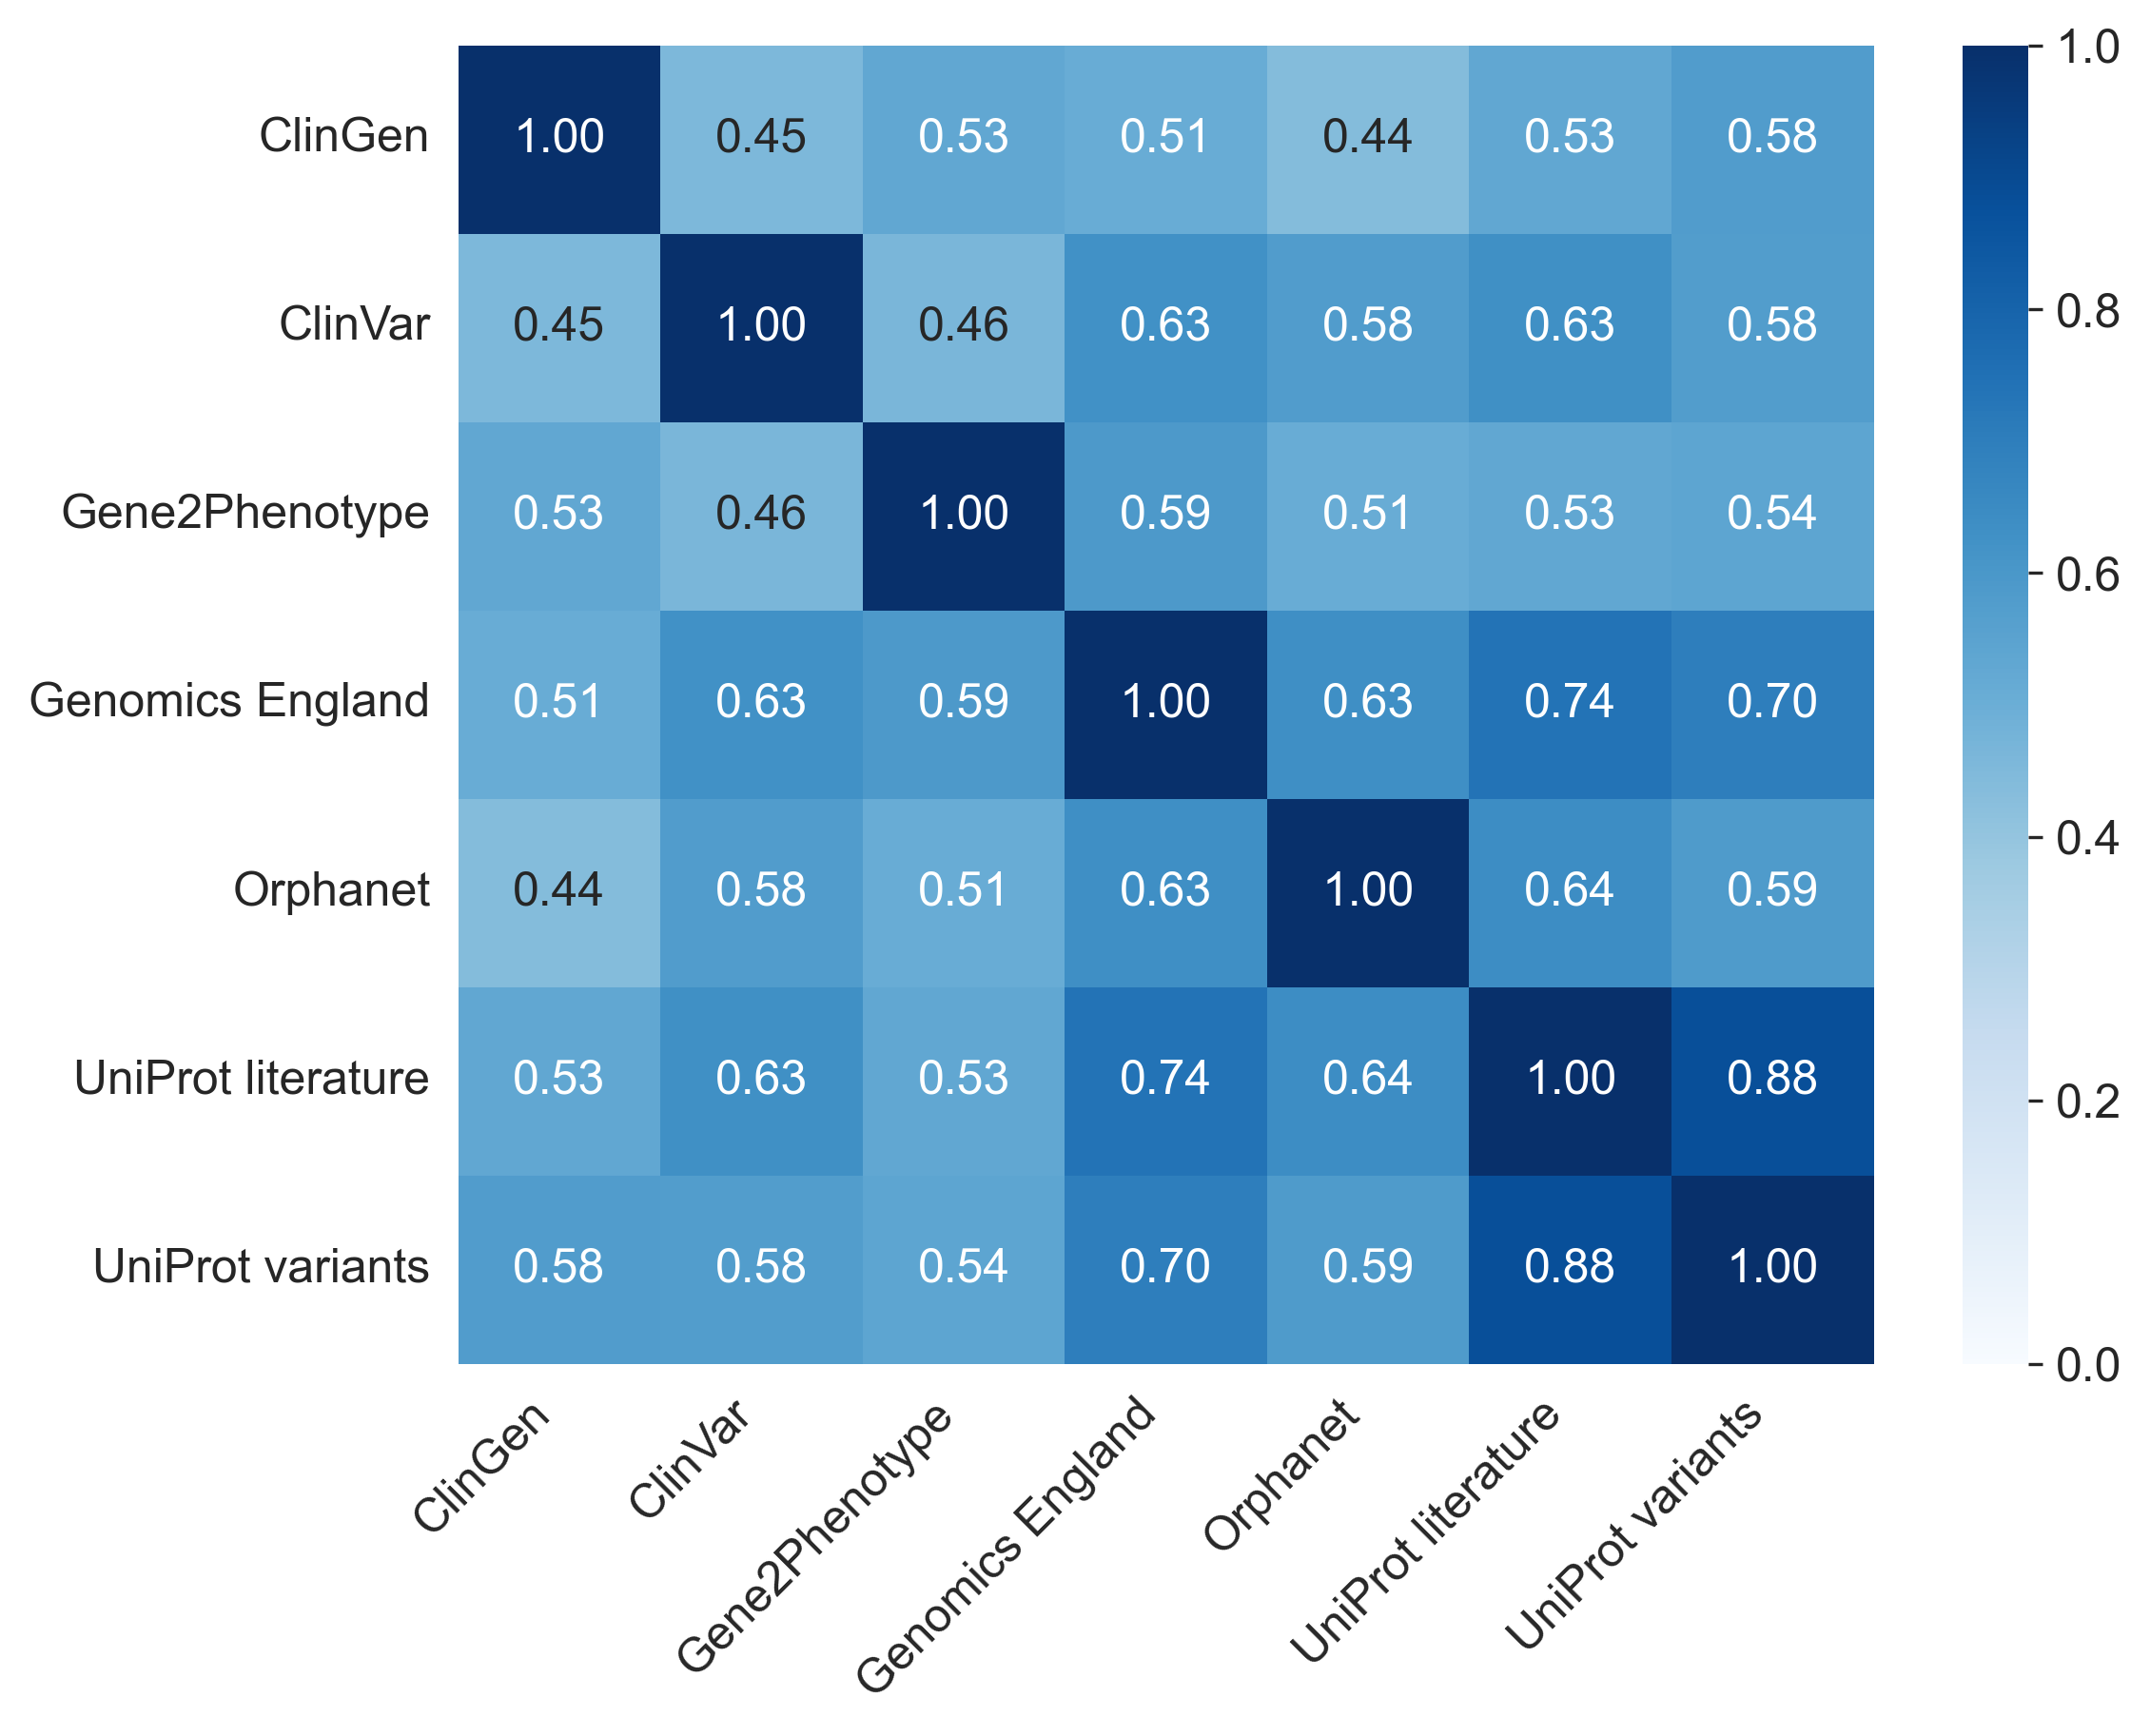

In [3]:
cm = indata[ot_clin].set_axis(['ClinGen','ClinVar','Gene2Phenotype','Genomics England',
                            'Orphanet','UniProt literature','UniProt variants'],axis=1)
cm = cm.corr()

plt.figure(figsize=(8, 6), dpi=300)
sns.set_style('white')

sns.heatmap(cm, cmap='Blues', vmin=0, annot=True, fmt=".2f")
a = plt.xticks(rotation=45, ha='right')


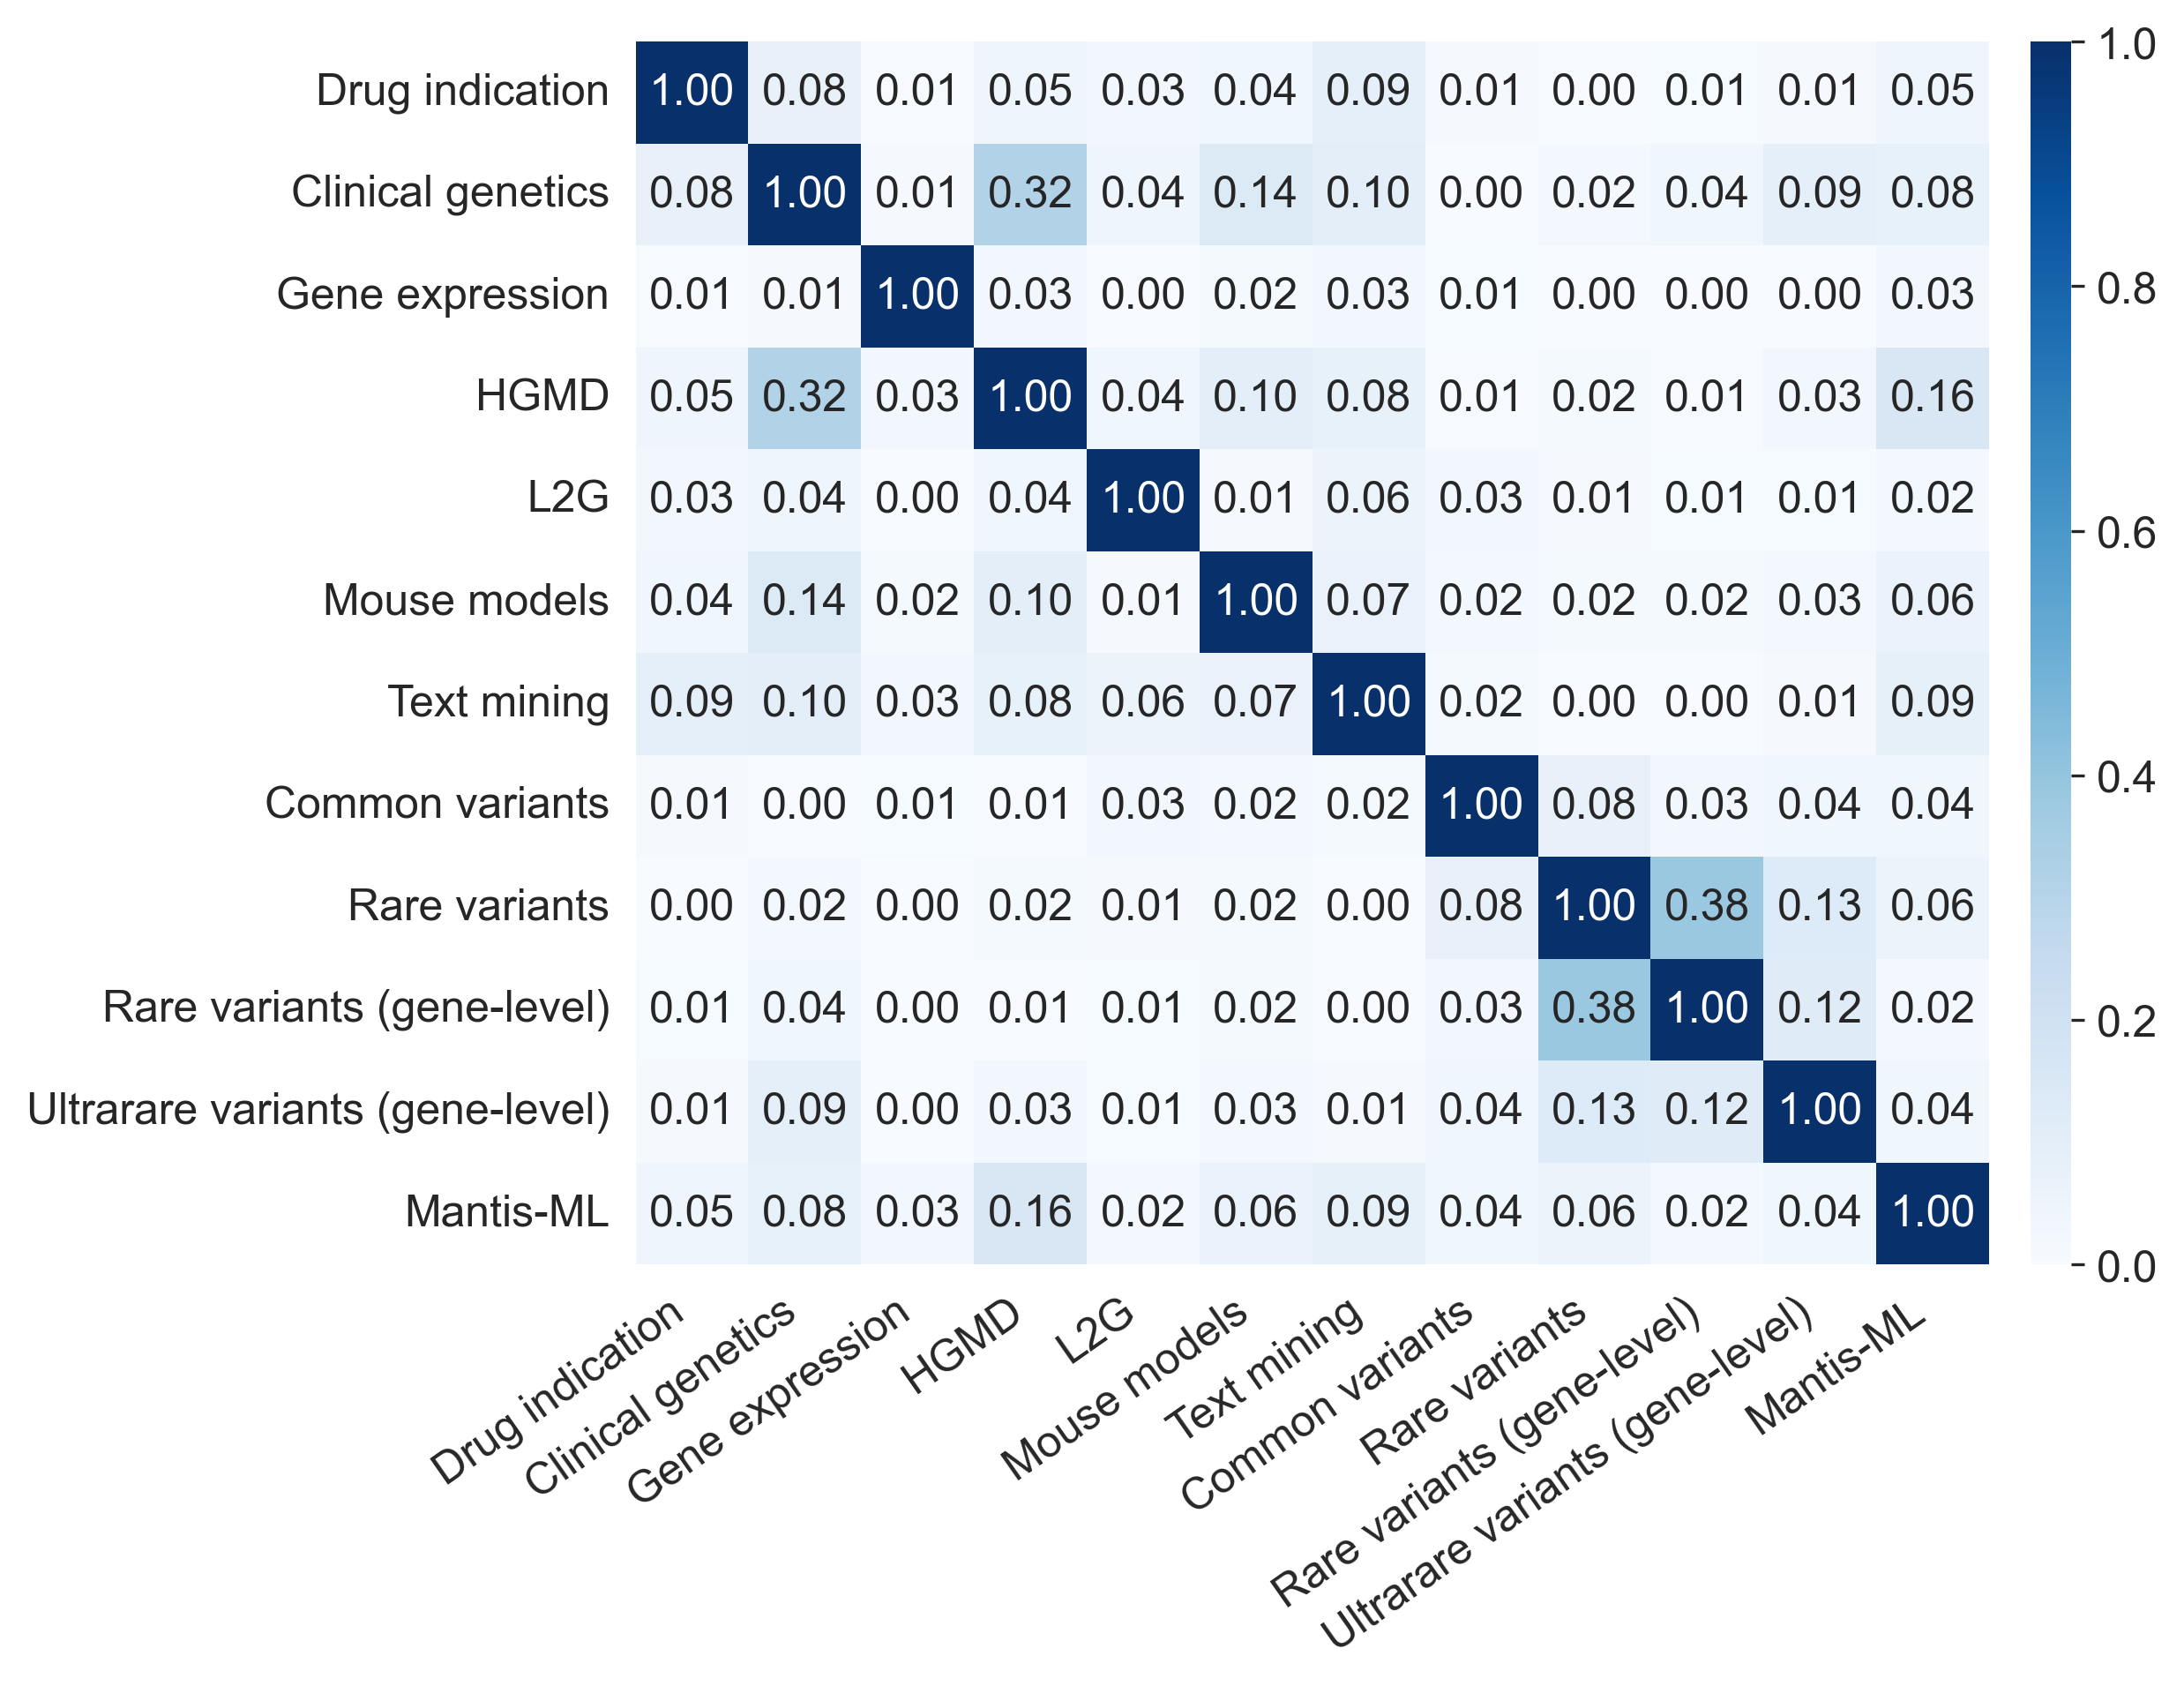

In [23]:
cm2 = indata[ot+mantis+cc+['indication']]
cm2['mantis'] = cm2['mantis'].fillna(0)
cm2['cc_common_max_p'] = cm2['cc_common_max_p'].fillna(0)
cm2 = cm2.set_axis(['Clinical genetics','HGMD','L2G','Gene expression','Mouse models','Text mining',
                    'Mantis-ML','Common variants','Rare variants','Rare variants (gene-level)','Ultrarare variants (gene-level)',
                    'Drug indication'],axis=1)
cm2 = cm2[['Drug indication','Clinical genetics','Gene expression','HGMD','L2G','Mouse models','Text mining',
           'Common variants','Rare variants','Rare variants (gene-level)','Ultrarare variants (gene-level)','Mantis-ML']]
cm2 = cm2.corr()
cm2[cm2 < 0] = 0

fig, ax = plt.subplots(figsize=(8, 6), dpi=300)
sns.set_style('white')

sns.heatmap(cm2, cmap='Blues', vmin=0, annot=True, fmt=".2f", cbar_kws={'pad': 0.025, 'aspect':30})

if False:
    show_annot_array = np.asarray(cm2) >= 0.1
    for text, show_annot in zip(ax.texts, show_annot_array.ravel()):
        text.set_visible(show_annot)

a = plt.xticks(rotation=35, ha='right')
